In [7]:
import tensorflow as tf
with tf.device('/device:GPU:2'):
    import numpy as np

    dataset = np.zeros(shape=(50000,1000))
    for j in range(0,50000):
        for i in range(0,1000):
            if i % 2 == 1:
                dataset[j][i] = 100 * np.random.exponential()
            else:
                dataset[j][i] = 1/100 * np.random.exponential()

    from numpy import expand_dims
    from numpy import zeros
    from numpy import ones
    from numpy import vstack
    from numpy.random import randn
    from numpy.random import randint
    from keras.datasets.mnist import load_data
    from keras.optimizers import Adam
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import Reshape
    from keras.layers import Flatten
    from keras.layers import Conv2D
    from keras.layers import Conv2DTranspose
    from keras.layers import LeakyReLU
    from keras.layers import Dropout
    from matplotlib import pyplot
    def define_generator(z):
        model = Sequential()
        model.add(Dense(300, input_dim=z))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(700))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1000))
        model.add(LeakyReLU(alpha=0.2))
        return model

    def define_discriminator(x = (1000)):
        model = Sequential()
        model.add(Dense(70, input_dim=x))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(30))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(10))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        # compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model

    def define_gan(g_model, d_model):
        # make weights in the discriminator not trainable
        d_model.trainable = False
        # connect them
        model = Sequential()
        # add generator
        model.add(g_model)
        # add the discriminator
        model.add(d_model)
        # compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt)
        return model

    def generate_real_samples(dataset, n_samples):
        # choose random instances
        ix = randint(0, dataset.shape[0], n_samples)
        # retrieve selected images
        X = dataset[ix]
        # generate 'real' class labels (1)
        y = ones((n_samples, 1))
        return X, y

    def generate_latent_points(latent_dim, n_samples):
        # generate points in the latent space
        x_input = randn(latent_dim * n_samples)
        # reshape into a batch of inputs for the network
        x_input = x_input.reshape(n_samples, latent_dim)
        return x_input

    def generate_fake_samples(g_model, latent_dim, n_samples):
        # generate points in latent space
        x_input = generate_latent_points(latent_dim, n_samples)
        # predict outputs
        X = g_model.predict(x_input)
        # create 'fake' class labels (0)
        y = zeros((n_samples, 1))
        return X, y

    def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
        # prepare real samples
        X_real, y_real = generate_real_samples(dataset, n_samples)
        # evaluate discriminator on real examples
        _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
        # evaluate discriminator on fake examples
        _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
        # summarize discriminator performance
        print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

    def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
        bat_per_epo = int(dataset.shape[0] / n_batch)
        half_batch = int(n_batch / 2)
        # manually enumerate epochs
        for i in range(n_epochs):
            # enumerate batches over the training set
            for j in range(bat_per_epo):
                # get randomly selected 'real' samples
                X_real, y_real = generate_real_samples(dataset, half_batch)
                # generate 'fake' examples
                X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
                # create training set for the discriminator
                X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
                # update discriminator model weights
                d_loss, _ = d_model.train_on_batch(X, y)
                # prepare points in latent space as input for the generator
                X_gan = generate_latent_points(latent_dim, n_batch)
                # create inverted labels for the fake samples
                y_gan = ones((n_batch, 1))
                # update the generator via the discriminator's error
                g_loss = gan_model.train_on_batch(X_gan, y_gan)
                # summarize loss on this batch

            # evaluate the model performance, sometimes
            if (i+1) % 10 == 0:
                print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
                summarize_performance(i, g_model, d_model, dataset, latent_dim)

    # size of the latent space
    latent_dim = 100
    # create the discriminator
    d_model = define_discriminator()
    # create the generator
    g_model = define_generator(latent_dim)
    # create the gan
    gan_model = define_gan(g_model, d_model)
    # train model
    train(g_model, d_model, gan_model, dataset, latent_dim)
    

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>10, 39/39, d=0.509, g=0.623
>Accuracy real: 97%, fake: 0%
>20, 39/39, d=0.321, g=1.094
>Accuracy real: 100%, fake: 100%
>30, 39/39, d=0.576, g=1.224
>Accuracy real: 68%, fake: 100%
>40, 39/39, d=0.475, g=1.693
>Accuracy real: 62%, fake: 100%
>50, 39/39, d=0.571, g=1.038
>Accuracy real: 88%, fake: 41%
>60, 39/39, d=0.732, g=2.527
>Accuracy real: 37%, fake: 100%
>70, 39/39, d=0.545, g=1.369
>Accuracy real: 92%, fake: 90%
>80, 39/39, d=0.462, g=1.002
>Accuracy real: 90%, fake: 90%
>90, 39/39, d=0.515, g=1.585
>Accuracy real: 78%, fake: 98%
>100, 39/39, d=0.563, g=1.033
>Accuracy real: 67%, fake: 73%
>110, 39/39, d=0.510, g=1.498
>Accuracy real: 68%, fake: 98%
>120, 39/39, d=0.385, g=1.606
>Accuracy real: 80%, fake: 89%
>130, 39/39, d=0.723, g=0.975
>Accuracy real: 85%, fake: 48%
>140, 39/39, d=0.531, g=1.152
>Accuracy real: 67%, fake: 78%
>150, 39/39, d=0.773, g=2.394
>Accuracy real: 34%, fake: 99%
>160, 39/39, d=0.794, g=1.135
>Accuracy real: 85%, fake: 48%
>170, 39/39, d=0.585, g=0.944

In [2]:
g_model.save('Gan')

In [20]:
import tensorflow as tf
with tf.device('/device:GPU:2'):
    def generate_latent_points(latent_dim, n_samples):
        # generate points in the latent space
        x_input = randn(latent_dim * n_samples)
        # reshape into a batch of inputs for the network
        x_input = x_input.reshape(n_samples, latent_dim)
        return x_input
    latent_points = generate_latent_points(100, 1000)

    # generate images
    X = g_model.predict(latent_points)

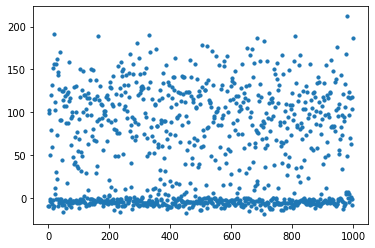

In [54]:
from statistics import median
median_ = np.zeros(shape=(len(X,)))
for i in range(0,len(X)):
    median_[i] = median(X[:,i])
import matplotlib.pyplot as plt
plt.scatter(x=range(0,len(median_)),y=median_,s=10)
plt.show()

In [43]:
odd = []
even = []
for i in range(0,len(X)):
    if i % 2 == 0:
        odd.append(median_[i])
    else:
        even.append(median_[i])

## Sequence of 1/100 * exp(1)

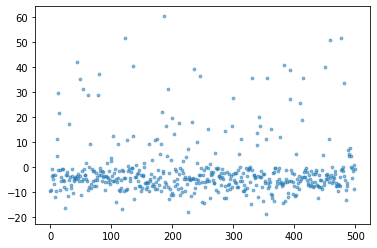

In [52]:
plt.scatter(x=range(0,len(odd)),y=odd,alpha = 0.5,s=8)
plt.show()

## Sequence of 100 * exp(1)


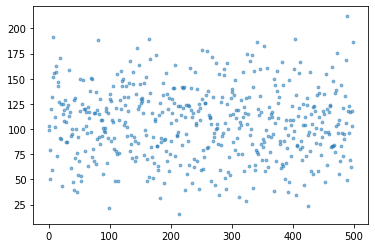

In [53]:
plt.scatter(x=range(0,len(even)),y=even,alpha = 0.5,s=8)
plt.show()